# ResNetとVGG

## Model architecture tuning & score optimization


Some ideas and code taken from ealier [kernel](https://www.kaggle.com/wrosinski/clean-workflow-in-keras) and last prepared notebook.

Having dealt with data processing & engineering of channel features, next step of modeling is preparation and tuning of model architecture. Earlier notebooks provided a way to create images with three channels, which will facilitate usage of pretrained models.

For segmentation tasks, a pretrained model can be used as encoder part of the final architecture. 
In order to use pretrained models, we will have to extract features from a few intermediate layers, which will then serve as a basis for layers coming afterwards and for skip connections between encoder and decoder part.

ResNet50 is a good starting point, because it consists of 4 blocks, where each one of them can serve as feature extractor with first layer serving as the 5th extractor to achieve consistency with standard UNet architecture.

## 【問題1】コードレビュー

- 前回使用した実装とはどのように違うのか

畳み込みの層が前回とは違いノード数を少なくして行っている

- 転移学習をどのように行っているか

エンコーダーブロックとデコーダーブロックを組み合わせて学習させている

In [2]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.losses import binary_crossentropy
from keras.applications.vgg19 import VGG19, preprocess_input
import warnings #ワーニング関連のモジュール？
warnings.filterwarnings('ignore') #ワーニングが消える？

%matplotlib inline

In [3]:
# 図の縦横のサイズ([横(inch),縦(inch)])
plt.rcParams['figure.figsize'] = (12, 9)
# plt.style.use('ggplot')

In [11]:
# coverage=網羅率,どれだけカバーしているか
def compute_coverage(df, masks):
    """領域割合の計算とクラスの付与
    Parameters
    ------------
    train_df : df
    masks : セグメンテーション画像
    """
    df = df.copy()
    
    def cov_to_class(val):
        """領域割合からクラスを付与
        val : セグメンテーション領域の割合
        """
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # Output percentage of area covered by class
    # masksの　行と列ごとの平均値(３次元の場合axis=0は奥行きになる)
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # Coverage must be split into bins, otherwise stratified split will not be possible,
    # because each coverage will occur only once.
    # 
    df['coverage_class'] = df.coverage.map(
        cov_to_class)

    return df


def create_depth_abs_channels(image_tensor):
    """3チャンネルに拡張
    """
    # image_tensorをnp.float32型に変換
    image_tensor = image_tensor.astype(np.float32)
    # image_tensorのshapeの値をh,w,cに代入
    h, w, c = image_tensor.shape
    # np.linspace(start,stop,要素数)
    # enumerate(インデックス番号,要素)
    for row, const in enumerate(np.linspace(0, 1, h)):
        # row=インデックス番号
        # const=要素で代入
        image_tensor[row, :, 1] = const
    # 全チャンネル、全行の　０列と１列をかけて２列目に代入する
    image_tensor[:, :, 2] = (image_tensor[:, :, 0] * image_tensor[:, :, 1])

    # np.diff(差分を取りたい配列,axis=方向)
    # image_tensor[:, :, 0], axis=0(全てのチャンネルと全ての行の０列目の差分）
    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    
    # cv2.copyMakeBorder=(入力画像,top,bottom,left,right,borderType,value)
    # cv2.BORDER_CONSTANT=単一色の境界を追加します．次の引数で色の指定をします．
    # value - フラグが cv2.BORDER_CONSTANT の時に指定する境界の色
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    
    # np.abs=配列の各要素に対して、絶対値を取った配列を作る関数
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)

    return image_tensor

### Data loading & depth merge:

In [7]:
# データの読み込みと深度のマージ
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/sample_submission.csv')
depth = pd.read_csv('data/depths.csv')

train_src = 'data/train/'

# 出力
display(train.head())
display(test.head())

# 共通のデータ列を持っている複数のpd.DFをその列の値に従って結合させる
# .merge(結合させるDF、how=結合方向,on=キーとなる列名)
train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

# 出力
display(train.head())
display(test.head())

,id,rle_mask
0,2c45b152f1,99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...
1,3cb59a4fdc,1 5656
2,e185ab5dc1,4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...
3,c78c89577c,101 1
4,6306dd3a8e,1 30 102 29 203 29 304 28 405 27 506 27 607 26...


,id,rle_mask
0,3e06571ef3,1 1
1,a51b08d882,1 1
2,c32590b06f,1 1
3,15f7a047c7,1 1
4,e8827bc832,1 1


,id,rle_mask,z
0,2c45b152f1,99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...,312
1,3cb59a4fdc,1 5656,603
2,e185ab5dc1,4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...,687
3,c78c89577c,101 1,236
4,6306dd3a8e,1 30 102 29 203 29 304 28 405 27 506 27 607 26...,805


,id,rle_mask,z
0,3e06571ef3,1 1,232
1,a51b08d882,1 1,470
2,c32590b06f,1 1,682
3,15f7a047c7,1 1,653
4,e8827bc832,1 1,103


### Load images and masks, examine random sample:

画像とマスクをロードし、ランダムなサンプルを調べます

In [8]:
# np.asarray 同期され続ける配列のコピーを作る
X_train = np.asarray(
    # cv2.imread=画像ファイルから読み込み(ファイル,cv2.IMREAD_GRAYSCALE=0(グレースケール））
    # tolistでリスト型のID分繰り返す
    [cv2.imread('data/train/images/{}.png'.format(x), 0) for x in train.id.tolist()
    ],
    # uint8=符号なし8ビット整数型
    dtype=np.uint8) / 255. #正規化
y_train = np.asarray(
    [cv2.imread('data/train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
    dtype=np.uint8) / 255.

# 確認
print(X_train.shape, y_train.shape)

(4000, 101, 101) (4000, 101, 101)


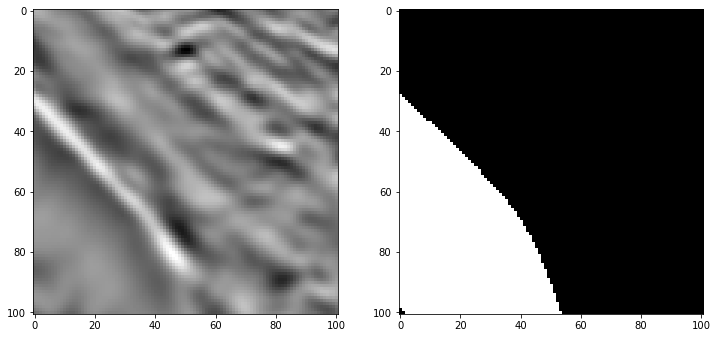

In [9]:
# np.random.randint(任意の範囲の整数の乱数を返す)
# (low, high=None, size=None, dtype='l')
random_index = np.random.randint(0, X_train.shape[0])

# FigureとAxesを同時に生成
# fig, axes = plt.subplots(nrows, ncols)
# nrows×ncols個のサブプロットを生成
fig, ax = plt.subplots(1, 2)

# グレースケールで描画
ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray')

### Compute salt coverage (this will serve as a basis for stratified split):

ソルトカバレッジを計算します（これは層化分割の基礎として機能します

In [10]:
train = compute_coverage(train, y_train)

### Prepare data for training:

In [13]:
# K個に分け、1個をtestデータに、K-1個をtrainデータとする
kfold = StratifiedKFold(n_splits=5)#, random_state=1337)

# Add channel features
# np.expand_dims(新たな次元を追加) -1だと最後尾に
X_ed = np.expand_dims(X_train, axis=-1)
# np.repeat(配列,繰り返し回数,axis)
X_train_ch = np.repeat(X_ed, 3, -1)
# lambda 簡易的な関数　　引数：戻り値
# map(lambda 引数: 処理, シーケンス)
# 全てのシーケンスの値に対してlambdaを適用させる
# list()でリスト型に変換
# np.asarray(同調される配列を作成)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# Resize to 224x224, default ResNet50 image size
# cv2.resize(入力画像,(w,h))
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))

# kfold.splitで分割してfor文で回す
for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
    # リサイズしたX,yをtrain,valに代入
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    
    break
    
# np.expand_dims(新たな次元を追加) -1だと最後尾に
y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

# 確認
print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)


del X_train_ch, y_resized
del X_resized
# すべてのジェネレーションのガベージ コレクションを強制的に実行します。
gc.collect()

(3200, 224, 224, 3) (3200, 224, 224, 1)
(800, 224, 224, 3) (800, 224, 224, 1)


24

### Loss functions & metric:

損失関数とメトリック

In [14]:

from keras.losses import binary_crossentropy


# Dice & combined
def dice_coef(y_true, y_pred):
    
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    """dice損失の計算
    DICE損失参考：https://qiita.com/ppza53893/items/8090322792e1c7f81e57
    """
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    """binary_crossentropyとdice加算した統合損失
    """
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

# バイナリ損失
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    """IOUの計算
    IOU参考：https://www.sigfoss.com/developer_blog/detail?actual_object_id=147
    A : 正解データ
    B : 0.5より大きければ1 0.5以下なら0に変換された予測領域
    """
    # バッチ数取得   
    batch_size = A.shape[0]
    # 最終的な評価指標 
    metric = 0.0
     # バッチ数でループ
    for batch in range(batch_size):
        # 引数A,Bより配列抽出
        t, p = A[batch], B[batch]
        # 正しい領域のピクセル
        true = np.sum(t)
        # 推定した領域のピクセル
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        # 正しく領域と推定されたピクセル
        intersection = np.sum(t * p)
        
        # IOU計算
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        # 実際のIOUに近似
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        # 最終的な評価指標に加算
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

### Encoder features - ResNet50:

In ResNet50, each block finishes with a pooling layer, so we can extract features from intermediate layers just before the pooling. This way, when first layer is added as additional extractor, we will have features extracted from 5 layers.
Default input size will be assumed, which is (224, 224, 3).
Layers will be as follows:

ResNet50では、各ブロックがプーリングレイヤーで終了するため、プーリングの直前に中間レイヤーから特徴を抽出できます。このように、最初のレイヤーが追加のエクストラクターとして追加されると、5つのレイヤーから特徴が抽出されます。デフォルトの入力サイズ（（224、224、3））が想定されます。レイヤーは次のようになります。

- 'activation_1', shape: (None, 112, 112, 64)
- 'activation_10', shape: (None, 56, 56, 256)
- 'activation_22', shape: (None, 28, 28, 512)
- 'activation_40', shape: (None, 14, 14, 1024)
- 'activation_49', shape: (None, 7, 7, 2048)

One thing to keep in mind is that every time a model will be created in the same TF session in the notebook, layer names will change, so above layer names correspond to first creation of the model. In order to reset session, call `K.clear_session()`.

ノートブックの同じTFセッションでモデルが作成されるたびに、レイヤー名が変更されるため、上記のレイヤー名はモデルの最初の作成に対応することに注意してください。セッションをリセットするには、 `K.clear_session（）`を呼び出します。

In [15]:
# 入力のshape定義
input_size = (224, 224, 3)
# 深さが 50 層の畳み込みニューラル ネットワーク
# ライブラリのimportの際に読み込んでおいたResNet50をインスタンス化
# 全結合層を場外する指定：include_top=False
base_model = ResNet50(input_shape=input_size, include_top=False)
base_model.summary()


94658560/94653016 [==============================] - 233s 2us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_______________________

### Decoder blocks:

デコーダーブロック

Features from ResNet50 will serve as a basis for encoder part of the segmentation model, now a decoder part is needed.
For this part, we will have to create our own blocks. Let's create a very basic block and a second one, which structure will have a more complicated structure.

ResNet50の機能は、セグメンテーションモデルのエンコーダー部分の基礎として機能します。ここで、デコーダー部分が必要になります。
この部分では、独自のブロックを作成する必要があります。非常に基本的なブロックと2つ目のブロックを作成しましょう。これらの構造は、より複雑な構造になります。

In [18]:
# Basic decoder block with Conv, BN and PReLU activation.
# Conv、BN、およびPReLUがアクティブ化された基本的なデコーダー
def decoder_block_simple(layer_name,
                         block_name,
                         num_filters=32,
                         conv_dim=(3, 3)):
    """デコーダーブロック
    Parameters
    ------------
    layer_name : 前の層のインスタンス
    block_name : この層のベースとなる名前
    num_filters : フィルター数
    conv_dim : フィルターサイズ
    """
    # 畳み込み
    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    # バッチ正規化
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    # 活性化関数（PReLU）
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.
# 表現を圧縮するために、中間のconvレイヤーが最初と最後の半分のサイズであるボトルネックアーキテクチャーを備えたデコーダーブロック。
# このタイプのアーキテクチャは、最も有用な情報を保持することになっています。

def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):
    """複雑なデコーダーブロック
    Parameters
    ------------
    layer_name : 前の層のインスタンス
    block_name : この層のベースとなる名前
    num_filters : フィルター数
    conv_dim : フィルターサイズ
    dropout_frac : ドロップアウト率
    """

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

### Model definition:

モデル定義

Combine encoder and decoder blocks to create final segmentation model.

エンコーダーブロックとデコーダーブロックを組み合わせて、最終的なセグメンテーションモデルを作成します。

In [16]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.

# モデルは、decoder_block_simpleのような関数を指定できる引数であるため、
# decoder_blockタイプを簡単に変更できるようにパラメーター化されています。

def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):
    """resnetを模倣したunet構造のネットワーク
    Parameters
    ------------
    input_size    : 入力サイズ
    decoder_block : デコーダーブロック
    weights       : 重みの初期値　        default:imagenet,
    loss_func     : 損失関数　            default:binary_crossentropy
    metrics_list  : 指標一覧　            default:[my_iou_metric]
    use_lovash    : lavash使うか         default:False
    """

    # Base model - encoder
    # resnet50のベースモデル
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    # ベースモデルの特徴抽出のためのレイヤー
    encoder1 = base_model.get_layer('conv1').output # activation_1
    encoder2 = base_model.get_layer('res2c_branch2c').output # activation_10
    encoder3 = base_model.get_layer('res3d_branch2c').output # activation_22
    encoder4 = base_model.get_layer('res4f_branch2c').output # activation_40
    encoder5 = base_model.get_layer('res5c_branch2c').output # activation_40

    # Center block
    # センターブロック
    # ①encoder5の出力をデコーダーブロックに渡す
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    
    # ②encoder5と①を結合
    concat5 = concatenate([center, encoder5], axis=-1)

    # デコーダー部分
    # すべてのデコーダーブロックは、エンコーダーとデコーダー部分からの連結出力を処理しました。
    # これによりスキップ接続が作成されます。
    # その後、デコーダー出力はエンコーダー出力部分に等しい次元にアップサンプリングされます。
    
    # ①concat5,の出力をデコーダーブロックに渡す
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    # ②①をupsamplingする
    # ③encoder4と②を結合する
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    # ①～③を繰り返し
    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    # セグメンテーションのための最終的なアップサンプリングとデコーダーブロック。
    # UpSampling2D(size=(2, 2), data_format=None)
    # 2次元の入力に対するアップサンプリングレイヤー
    # データの行と列をそれぞれsize[0]及びsize[1]回繰り返します
    
    # 再度upsamplingする
    output = UpSampling2D()(concat1)
    
    # デコーダーブロックに通す
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    
    # 2次元の畳み込みレイヤー（例えばイメージに対する空間的畳み込み）
    #Conv2D(filters, kernel_size, strides=(1, 1), 
    #      padding='valid', data_format=None, dilation_rate=(1, 1), 
    #.     activation=None, use_bias=True, kernel_initializer='glorot_uniform', 
    #.     bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
    #.     activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
      
    # モデルの結合
    model = Model(base_model.input, output)
    # 損失・最適化手法・指標一覧を与えて、コンパイル
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    # モデルを返す
    return model

### Inspect created model:

作成したモデルを検査する

In [19]:
input_size = (224, 224, 3)


K.clear_session()
model = unet_resnet(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLaye

## 【問題3】学習・推定

ResNetとVGG双方のコードで学習・推定を行い、結果を比較してください。

### Train model:

訓練モデル

In [20]:
K.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.

# モデルの構築
# ここでは、さまざまな損失を試すことができます。
# サイコロとBCE（binary_crossentropy）の場合、my_iou_metricを使用する必要があります。
# 一方、lovash_lossの場合は、値の範囲が広いため、my_iou_metric2を使用する必要があります。
# ロバッシュ損失の場合は、BCEとサイコロの場合のように0から1の間ではなく、-infから+ infの間です。
# さらに、ロバッシュロスを使用する場合は、最後のレイヤー（シグモイド）を削除する必要があります。
# これはuse_lovashパラメーターによって制御されます。


model_depth = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(model_depth.summary())

# ModelCheckpoint(filepath: 重みのファイル名そのものを指示
#                 monitor: 監視する値
#                 verbose: 0=結果非表示　1=結果表示
#                 save_best_only: True=判定結果から保存を決定。False=後述の'period'の間隔で保存
#                 mode: 判定条件(auto、max、min)
#                 save_weights_only: True=モデルの重みが保存。False=モデル全体を保存
#                 period: 何エポックごとに保存するか
# モデルの保存設定
model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)

# 学習率の減衰設定
# val_my_iou_metricの改善が5エポック見られなかったら、学習率を0.5倍する。
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)

# 学習回数
epochs = 2  # 25
# バッチ数
batch_size = 16

# 学習の実行と学習過程の取得
history = model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

### Validation set prediction and resizing to original size:

検証セットの予測と元のサイズへのサイズ変更

In [21]:
# 予測
val_preds = model_depth.predict(X_val, batch_size=16)

# 元の大きさにリサイズ
y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

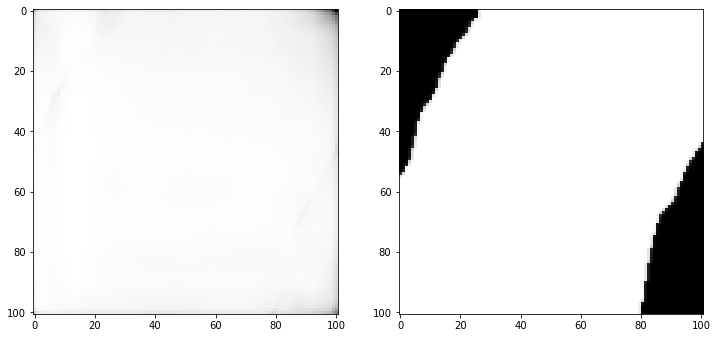

In [29]:
# 描画

# np.random.randint(任意の範囲の整数の乱数を返す)
# (low, high=None, size=None, dtype='l')
random_index = np.random.randint(0, y_val_pred.shape[0])

# FigureとAxesを同時に生成
# fig, axes = plt.subplots(nrows, ncols)
# nrows×ncols個のサブプロットを生成
fig, ax = plt.subplots(1, 2)

# グレースケールで描画
ax[0].imshow(y_val_pred[random_index], cmap='gray')
ax[1].imshow(y_val_true[random_index], cmap='gray')

## 【問題2】コードの書き換え

エンコーダーにResNetが使用されていたコードをVGGに変更してください。

In [30]:
def unet_vgg(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):
    """resnetを模倣したunet構造のネットワーク
    Parameters
    ------------
    input_size    : 入力サイズ
    decoder_block : デコーダーブロック
    weights       : 重みの初期値　        default:imagenet,
    loss_func     : 損失関数　            default:binary_crossentropy
    metrics_list  : 指標一覧　            default:[my_iou_metric]
    use_lovash    : lavash使うか         default:False
    """

    # Base model - encoder
    # resnet50のベースモデル
    base_model = VGG19(input_shape=input_size,
                       include_top=False,
                       weights=weights)
    
    # Layers for feature extraction in the encoder part
    # ベースモデルの特徴抽出のためのレイヤー
    encoder1 = base_model.get_layer('block1_conv2').output # (224,224,64)
    encoder2 = base_model.get_layer('block2_conv2').output # (112,112,228)
    encoder3 = base_model.get_layer('block3_conv4').output # (56,56,256)
    encoder4 = base_model.get_layer('block4_conv4').output # (28,28,512)
    encoder5 = base_model.get_layer('block5_conv4').output # (14,14,512)

    # Center block
    # センターブロック
    # ①encoder5の出力をデコーダーブロックに渡す
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    
    # ②encoder5と①を結合
    concat5 = concatenate([center, encoder5], axis=-1)

    # デコーダー部分
    # すべてのデコーダーブロックは、エンコーダーとデコーダー部分からの連結出力を処理しました。
    # これによりスキップ接続が作成されます。
    # その後、デコーダー出力はエンコーダー出力部分に等しい次元にアップサンプリングされます。
    
    # ①concat5,の出力をデコーダーブロックに渡す
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    # ②①をupsamplingする
    # ③encoder4と②を結合する
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    # ①～③を繰り返し
    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    # セグメンテーションのための最終的なアップサンプリングとデコーダーブロック。
    # UpSampling2D(size=(2, 2), data_format=None)
    # 2次元の入力に対するアップサンプリングレイヤー
    # データの行と列をそれぞれsize[0]及びsize[1]回繰り返します
    
    # デコーダーブロックに通す
    output = decoder_block(
        concat1, 'decoder_output', num_filters=32)
    
    # 2次元の畳み込みレイヤー（例えばイメージに対する空間的畳み込み）
    #Conv2D(filters, kernel_size, strides=(1, 1), 
    #      padding='valid', data_format=None, dilation_rate=(1, 1), 
    #.     activation=None, use_bias=True, kernel_initializer='glorot_uniform', 
    #.     bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
    #.     activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
      
    # モデルの結合
    model = Model(base_model.input, output)
    # 損失・最適化手法・指標一覧を与えて、コンパイル
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    # モデルを返す
    return model

In [32]:
# モデルの定義
model = unet_vgg(input_size, decoder_block_bottleneck, weights='imagenet',loss_func=bce_dice_loss, metrics_list=[my_iou_metric],use_lovash=False)
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [33]:
# 学習回数
EPOCHS = 2
# バッチ数
BATCH_NUM = 16

# モデルの保存設定
model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5',
    monitor='val_my_iou_metric',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
# 学習率の減衰設定
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1
)


# 学習の実行と学習過程の取得
history = model.fit(
    X_tr, y_tr,
    validation_data=[X_val, y_val], 
    epochs=EPOCHS,
    batch_size=BATCH_NUM,
    callbacks=[model_checkpoint,reduce_lr], 
    verbose=1
)

Train on 3200 samples, validate on 800 samples
Epoch 1/2
3200/3200 [==============================] - 3162s 988ms/step - loss: 0.9363 - my_iou_metric: 0.1247 - val_loss: 1.2855 - val_my_iou_metric: 0.0225

Epoch 00001: val_my_iou_metric improved from -inf to 0.02250, saving model to unet_resnet.h5
Epoch 2/2
3200/3200 [==============================] - 3167s 990ms/step - loss: 0.7786 - my_iou_metric: 0.2179 - val_loss: 1.0535 - val_my_iou_metric: 0.2630

Epoch 00002: val_my_iou_metric improved from 0.02250 to 0.26300, saving model to unet_resnet.h5


In [34]:
# 予測
val_preds = model.predict(X_val, batch_size=16)

# 元の大きさにリサイズ
y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

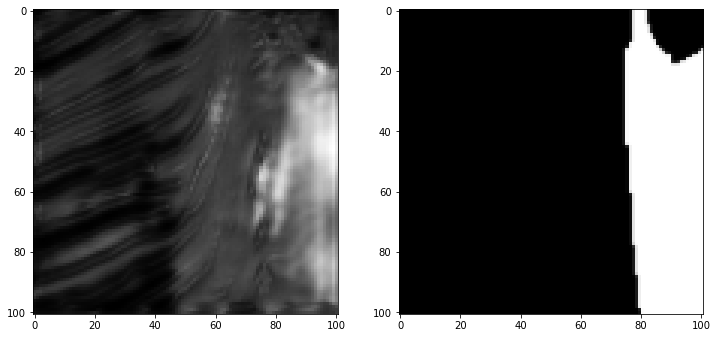

In [36]:
# 描画

# np.random.randint(任意の範囲の整数の乱数を返す)
# (low, high=None, size=None, dtype='l')
random_index = np.random.randint(0, y_val_pred.shape[0])

# FigureとAxesを同時に生成
# fig, axes = plt.subplots(nrows, ncols)
# nrows×ncols個のサブプロットを生成
fig, ax = plt.subplots(1, 2)

# グレースケールで描画
ax[0].imshow(y_val_pred[random_index], cmap='gray')
ax[1].imshow(y_val_true[random_index], cmap='gray')

### Threshold optimization: 

しきい値の最適化

In [37]:
# src: https://www.kaggle.com/aglotero/another-iou-metric

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    # 2つのデータサンプルの2次元ヒストグラムを計算します
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    # 計算領域（すべてのオブジェクト間の結合を見つけるために必要）
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    # ユニオンを計算する
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    # 分析から背景を除外する
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    # ユニオン上の交差を計算します
    iou = intersection / union

    # Precision helper function
    # 精密ヘルパー機能
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    # IoUしきい値をループします
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    # np.arange(strat,stop,公差)    
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [38]:
# Threshold range, over which optimization is performed
# 最適化が実行されるしきい値範囲
thresholds = np.arange(0.2, 0.9, 0.02)

# For every threshold, set predictions to binary arrays, 
# where values above threshold are treated as 1 and the rest as 0.
# Loop over thresholds and compute IoU for them based on IoU function above.
#すべてのしきい値について、予測をバイナリ配列に設定します。
#ここで、しきい値を超える値は1として扱われ、残りは0として扱われます。
#しきい値をループし、上記のIoU関数に基づいてしきい値のIoUを計算します。

ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:39<00:00,  1.13s/it]


In [39]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
# 最高のIoUのインデックスを取得する
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
# IoUDFを表示
df_iou.describe()

Best IoU: 0.4679 at threshold: 0.880


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.298532
std,0.204939,0.089431
min,0.200000,0.155125
25%,0.370000,0.235750
50%,0.540000,0.308000
75%,0.710000,0.356563
max,0.880000,0.467875


<AxesSubplot:xlabel='threshold'>

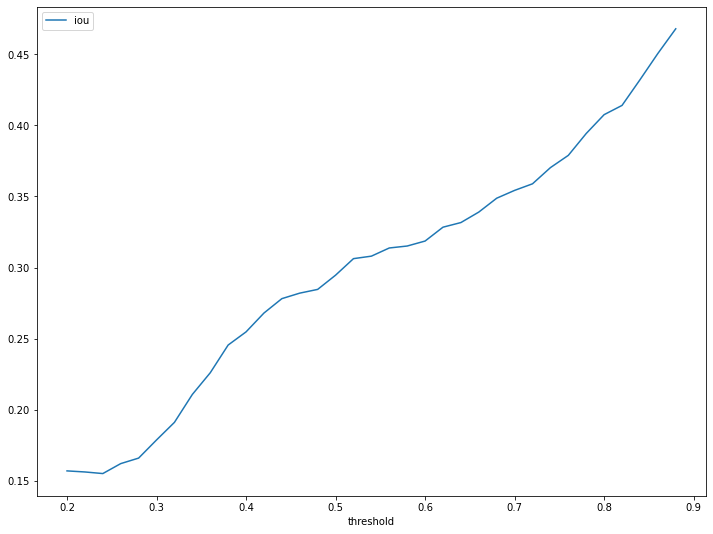

In [40]:
# Plot IoU values over threshold range.
# しきい値範囲を超えてIoU値をプロットします。
df_iou.plot(x='threshold', y='iou')

## Conclusions:

- Pretrained models can be used for segmentation problems:
    - Some of architectures can be easily adapted to the problem (ie ResNet)
    - Other architectures may require more experimentation with selection of proper layers for feature extraction and padding (example of using [Xception](https://www.kaggle.com/meaninglesslives/getting-0-87-on-private-lb-using-kaggle-kernel). )
    - You can experiment with selection of layers for feature extraction
    - For some models, you can also try to experiment with number of encoder/decoder blocks
- Threshold optimization is important in problems, where direct metric optimization during training is difficult.
    - It it possible to use more involved optimization methods (from [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html)), although this may not be optimal unless distribution of train and test set are very similar. Overoptimization of threshold or any other parameter on validation set may result in worse test set results.
- Experiment with various losses - BCE, Dice, combined BCE with Dice, Lovash loss.
    - Models trained with various losses may give different results, which may be advantageous when ensembling.


### Possible experiments:

- Change type of decoder block in created segmentation model
- Create your own decoder blocks
- Train with other losses
- Train longer
- Train with BCE/Dice, save the model, then load weights and finetune with Lovash loss
- Try different ranges and intervals for threshold optimization

In [41]:
np.int32(0.7 > 1)

0

In [42]:
def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric